In [139]:
%load_ext autoreload
%autoreload 2

import sys

import pandas as pd

import matplotlib.pyplot as plt

# get phospho data
ph_data = pd.read_pickle("./data/datasets/islets_PTP_dataset.pkl")
ph_sample_metadata = pd.read_pickle("./data/datasets/islets_PTP_sample_metadata.pkl")
ph_feature_metadata = pd.read_pickle("./data/datasets/islets_PTP_feature_metadata.pkl")

# parse position out of main identifier
ph_feature_metadata['aa_position'] = ph_feature_metadata.index.str.split('_').str[1]
ph_feature_metadata['position'] = ph_feature_metadata['aa_position'].replace('^.','',regex = True).astype(int)
ph_feature_metadata['uniprot_position'] = ph_feature_metadata['PG.UniProtIds'] + '_' + ph_feature_metadata['position'].astype(str)
ph_feature_metadata['Gene'] = ph_feature_metadata.index.str.split('_').str[0]

# functional annotation scores from [Ochoa, David, et al. "The functional landscape of the human phosphoproteome." Nature biotechnology 38.3 (2020): 365-373.]
fscores = pd.read_excel("./41587_2019_344_MOESM5_ESM.xlsx")
fscores['uniprot_position'] = fscores['uniprot'] + '_' + fscores['position'].astype(str)
fscores['GENE'] = fscores

# add functional scores to data
ph_feature_metadata = ph_feature_metadata.merge(fscores[['uniprot_position', 'functional_score']], on='uniprot_position', how='left')
ph_feature_metadata.set_index('PTM_collapse_key', inplace=True)

sys.path.append("src.py")
from src import Utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [141]:
fscores

,uniprot,position,functional_score,uniprot_position
0,A0A075B6Q4,24,0.149257,A0A075B6Q4_24
1,A0A075B6Q4,68,0.119811,A0A075B6Q4_68
2,A0A075B6T3,24,0.477724,A0A075B6T3_24
3,A0A075B759,68,0.087843,A0A075B759_68
4,A0A087WTJ2,8,0.168085,A0A087WTJ2_8
...,...,...,...,...
116253,Q9Y6M1,40,0.480261,Q9Y6M1_40
116254,Q9Y6N7,1038,0.636282,Q9Y6N7_1038
116255,Q9Y6N7,1476,0.405682,Q9Y6N7_1476
116256,Q9Y6Q9,574,0.328472,Q9Y6Q9_574


### [F10] Phosphoproteomics 

Visualize phosphoproteomics differential results alongside functional score annotations


In [127]:
# ttest comparison between cell types (control only) for phospho data

ph_diff_exp = {}

# alpha vs. delta:
mask = ph_sample_metadata['sample'].isin(['alpha', 'delta'])
ph_diff_exp['alpha_over_delta'] = Utils.group_ratios_ttest_ind(ph_data[mask], ph_sample_metadata[mask], between = 'sample').join(ph_feature_metadata, how = 'left')

# beta vs. delta:
mask = ph_sample_metadata['sample'].isin(['beta', 'delta'])
ph_diff_exp['beta_over_delta'] = Utils.group_ratios_ttest_ind(ph_data[mask], ph_sample_metadata[mask], between = 'sample').join(ph_feature_metadata, how = 'left')

# alpha vs. beta:
mask = ph_sample_metadata['sample'].isin(['alpha', 'beta'])
ph_diff_exp['alpha_over_beta'] = Utils.group_ratios_ttest_ind(ph_data[mask], ph_sample_metadata[mask], between = 'sample').join(ph_feature_metadata, how = 'left')


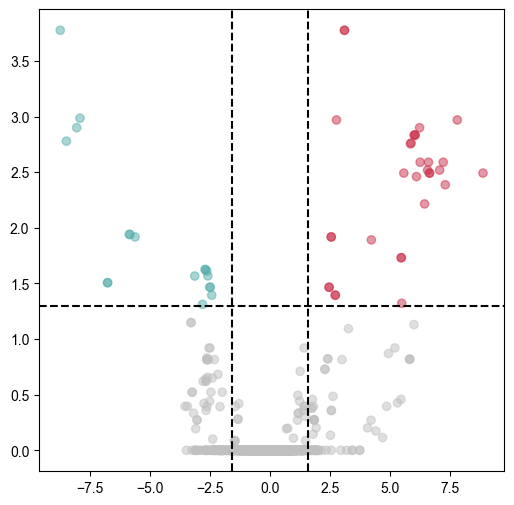

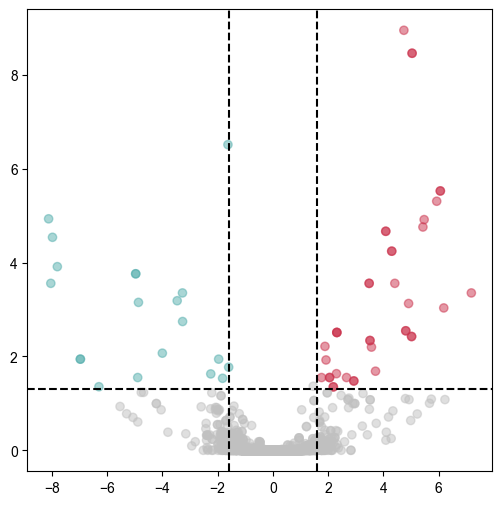

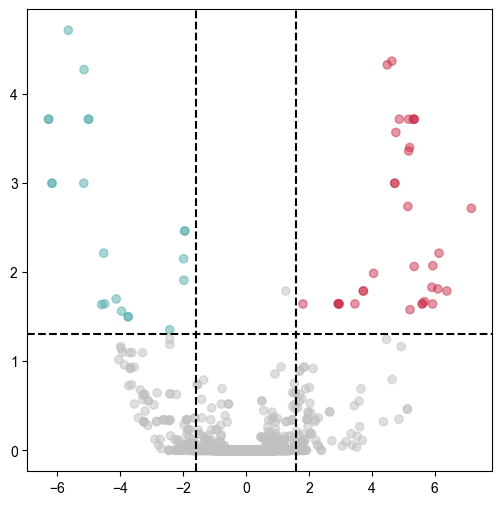

In [128]:
import numpy as np

# visualize and extract differentially regulated proteins
differentially_regulated_sites = {}
for comparison, diff_exp in ph_diff_exp.items():

    P_LIM = 0.05
    X_LIM = 3

    x_col = f'delta_{comparison}'
    y_col = f'padj_{comparison}'

    diff_exp[f'neg_log10_{y_col}'] = -np.log10(diff_exp[y_col])

    diff_exp['regulated'] = 'not regulated'
    diff_exp.loc[((diff_exp[x_col] > np.log2(X_LIM)) & (diff_exp[y_col] < P_LIM)), 'regulated'] = 'upregulated'
    diff_exp.loc[((diff_exp[x_col] < -np.log2(X_LIM)) & (diff_exp[y_col] < P_LIM)), 'regulated'] = 'downregulated'

    colormap = {
        'not regulated': '#C0C0C0',
        'upregulated': '#cb334d',
        'downregulated': '#54aead',
        'selected' : '#3a7eb8',
    }

    differentially_regulated_sites[comparison] = diff_exp[diff_exp['regulated'].isin(['upregulated', 'downregulated'])].copy()

    # plot volcano plot
    fig, ax = plt.subplots(figsize=(6, 6))

    ax.scatter(diff_exp[x_col], diff_exp[f'neg_log10_{y_col}'], c=diff_exp['regulated'].map(colormap), alpha=0.5)
    
    ax.axhline(y=-np.log10(P_LIM), color='black', linestyle='--')
    ax.axvline(x=np.log2(X_LIM), color='black', linestyle='--')
    ax.axvline(x=-np.log2(X_LIM), color='black', linestyle='--')

In [135]:
# ortholog mapping since this dataset is from M.musculus

from Bio import pairwise2
from Bio.Seq import Seq
from Bio import SeqIO

# try mapping the mouse UniProt IDs to human

In [136]:
differentially_regulated_sites['alpha_over_delta']

,ratio_alpha_over_delta,delta_alpha_over_delta,tvalue_alpha_over_delta,pvalue_alpha_over_delta,padj_alpha_over_delta,ratio_delta_over_alpha,delta_delta_over_alpha,tvalue_delta_over_alpha,pvalue_delta_over_alpha,padj_delta_over_alpha,...,PTM_group,PTM_collapse_key_num,PTM_localization,PTM_0_aa,aa_position,position,uniprot_position,functional_score,neg_log10_padj_alpha_over_delta,regulated
Arx_S20_M1,2.744680,6.244147,7.228439,1.667502e-05,0.002574,0.364341,-6.244147,-7.228439,1.667502e-05,0.002574,...,_S[Phospho (STY)]PTLLSSYC[Carbamidomethyl (C)]...,1,1.0,S,S20,20,O35085_20,NaN,2.589336,upregulated
Arx_S316_M2,2.853997,6.635386,8.609920,2.861045e-05,0.003224,0.350386,-6.635386,-8.609920,2.861045e-05,0.003224,...,_DGEDSVC[Carbamidomethyl (C)]LS[Phospho (STY)]...,1,1.0,S,S316,316,O35085_316,NaN,2.491568,upregulated
Arx_S319_M2,2.853997,6.635386,8.609920,2.861045e-05,0.003224,0.350386,-6.635386,-8.609920,2.861045e-05,0.003224,...,_DGEDSVC[Carbamidomethyl (C)]LS[Phospho (STY)]...,1,0.999,S,S319,319,O35085_319,NaN,2.491568,upregulated
Chgb_S100_M1,0.855021,-2.438800,-3.788419,7.471043e-04,0.040344,1.169562,2.438800,3.788419,7.471043e-04,0.040344,...,_WASS[Phospho (STY)]REDAGAPVEDSQGQTK_.2;_WASS[...,2,1.0,S,S100,100,P16014_100,NaN,1.394225,downregulated
Chgb_S301_M2,0.850987,-2.492762,-3.880471,5.838581e-04,0.034217,1.175106,2.492762,3.880471,5.838581e-04,0.034217,...,_SGSNKSS[Phospho (STY)]YEGHPLS[Phospho (STY)]E...,5,1.0,S,S301,301,P16014_301,NaN,1.465757,downregulated
Chgb_S308_M2,0.850157,-2.523322,-3.899315,5.579231e-04,0.034217,1.176253,2.523322,3.899315,5.579231e-04,0.034217,...,_SGSNKSSY[Phospho (STY)]EGHPLS[Phospho (STY)]E...,10,1.0,S,S308,308,P16014_308,NaN,1.465757,downregulated
Chgb_S342_M1,0.842715,-2.642800,-4.071980,3.501289e-04,0.024528,1.186640,2.642800,4.071980,3.501289e-04,0.024528,...,_AS[Phospho (STY)]EEEPEYGEESR_.2;_SHHLAHYRAS[P...,3,1.0,S,S342,342,P16014_342,NaN,1.610339,downregulated
Chgb_S342_M2,0.839971,-2.699576,-4.092317,3.296396e-04,0.023734,1.190517,2.699576,4.092317,3.296396e-04,0.023734,...,_AS[Phospho (STY)]EEEPEY[Phospho (STY)]GEESR_....,4,1.0,S,S342,342,P16014_342,NaN,1.624628,downregulated
Chgb_S493_M1,0.845430,-2.601564,-4.026637,3.964826e-04,0.027044,1.182830,2.601564,4.026637,3.964826e-04,0.027044,...,_WWQQEEQLGPEES[Phospho (STY)]REEVRFPDR_.3;_WWQ...,5,1.0,S,S493,493,P16014_493,NaN,1.567924,downregulated
Chgb_S626_M1,0.828269,-2.820941,-3.704299,9.415505e-04,0.048810,1.207337,2.820941,3.704299,9.415505e-04,0.048810,...,_ADEFPDFYDS[Phospho (STY)]EEQMGPHQEANDEK_.3;_A...,2,1.0,S,S626,626,P16014_626,NaN,1.311491,downregulated
